# Task 3

## Imports

In [2]:
import torch
from torch.utils.data import DataLoader, Dataset
from scipy.optimize import linear_sum_assignment
from torchvision import transforms
from tqdm import tqdm
import ultralytics
import os
import matplotlib.pyplot as plt
import numpy as np
np.random.seed(42)
import pandas as pd
import cv2
from IPython.display import Image
from ultralytics import YOLO
import pickle
import cv2
import numpy as np
from sklearn.cluster import KMeans
from collections import Counter
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from IPython.display import display, Image
import os
import json
import sys
import ast

ultralytics.checks()

''' to load a model and fine-tune it on a custom dataset, you can use the following code snippet:
yolo task=detect mode=train model=yolov8s.pt data=data.yaml epochs=10
yolo task=detect mode=val model=runs/detect/train/weights/best.pt data=data.yaml epochs=10
'''

df_values = pd.read_csv('data/values.csv')


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x7f83ba7449d0>>
Traceback (most recent call last):
  File "/home/m/.local/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(
KeyboardInterrupt: 


AttributeError: partially initialized module 'torch._dynamo' has no attribute 'external_utils' (most likely due to a circular import)

## Defining functions

In [ ]:
def render(image):
    if image.dtype == np.float64:
        image = cv2.convertScaleAbs(image)
    if len(image.shape) == 3 and image.shape[2] == 3: # BGR or RGB
        if np.array_equal(image[:, :, 0], image[:, :, 2]):
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    img_bytes = cv2.imencode('.png', image)[1].tobytes()
    display(Image(data=img_bytes))
    
def loadImage(num, imgLoadSizeRatio = 1, dataDir = 'data/imgs', standardSize = -1):
    img = cv2.imread(os.path.join(dataDir, f'{num}'))
    if standardSize > 0:
        img = cv2.resize(img, (standardSize, standardSize))
    elif imgLoadSizeRatio != 1:
        img = cv2.resize(img, (0, 0), fx = imgLoadSizeRatio, fy = imgLoadSizeRatio)
    return img

def get_file_names(directory):
    file_names = []
    for filename in os.listdir(directory):
        if os.path.isfile(os.path.join(directory, filename)):
            file_names.append(filename)
    return file_names
    
def run_yolo(yolo, image_url, conf=0.25, iou=0.7, showImage=True):
    results = yolo(image_url, conf=conf, iou=iou, verbose=False)
    img = cv2.cvtColor(results[0].plot()[:, :, [2,1,0]], cv2.COLOR_BGR2RGB)
    if showImage:
        render(img)
    bounding_boxes = results[0].boxes.xyxy.tolist()
    return bounding_boxes

def drawBB(img, bbs):
    img = img.copy()
    for bb in bbs:
        x1, y1, x2, y2 = [int(x) for x in bb]
        img = cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 2)
    return img

def getBBImages(image, bbs):
    bb_imgs = []
    for bb in bbs:
        x1, y1, x2, y2 = [int(x) for x in bb]
        cropped = image[y1:y2, x1:x2]
        bb_imgs.append(cropped)
    return bb_imgs
        
def getGrabCutMask(img):
    mask = np.zeros(img.shape[:2], np.uint8)
    bgModel = np.zeros((1, 65), np.float64)
    fgModel = np.zeros((1, 65), np.float64)
    rect = (0, 0, img.shape[1] - 1, img.shape[0] - 1)
    iterCount = 10
    cv2.grabCut(img, mask, rect, bgModel, fgModel, iterCount, cv2.GC_INIT_WITH_RECT)
    mask = np.where((mask == cv2.GC_FGD) | (mask == cv2.GC_PR_FGD), 1, 0).astype('uint8')
    return mask

def maskLego(lego_img):
    
    def reduce_colors_mean_shift(img, spatial_radius, color_radius):
        # Convert image to Lab color space
        lab_img = cv2.cvtColor(img, cv2.COLOR_BGR2Lab)
        
        # Perform mean shift clustering
        shifted_img = cv2.pyrMeanShiftFiltering(lab_img, spatial_radius, color_radius)
        
        # Convert the result back to BGR color space
        result_img = cv2.cvtColor(shifted_img, cv2.COLOR_Lab2BGR)
        
        return result_img
    
    spatial_radius = 50
    color_radius = 5

    # Reduce colors using mean shift clustering
    lego_img = reduce_colors_mean_shift(lego_img, spatial_radius, color_radius)

    bbColorBlurQnt = 1
    
    fg_mask = np.zeros(lego_img.shape[:2], np.uint8)
    
    while fg_mask.sum() == 0:
        lego_img_blurred = cv2.GaussianBlur(lego_img, (bbColorBlurQnt, bbColorBlurQnt), 0)
        fg_mask = getGrabCutMask(lego_img)
        bbColorBlurQnt -= 2
        if bbColorBlurQnt < 1 and fg_mask.sum() == 0:
            print('Failed to mask image')
            break
    
    # Masked image
    masked = cv2.bitwise_and(lego_img_blurred, lego_img_blurred, mask=fg_mask)
    return masked, fg_mask


def get_jaccard_index(ground_truth, predicted):
    x1, y1, x2, y2 = ground_truth
    x1_p, y1_p, x2_p, y2_p = predicted
    intersection = max(0, min(x2, x2_p) - max(x1, x1_p)) * max(0, min(y2, y2_p) - max(y1, y1_p))
    area_gt = (x2 - x1) * (y2 - y1)
    area_p = (x2_p - x1_p) * (y2_p - y1_p)
    union = area_gt + area_p - intersection
    return intersection / union

def getGroundTruths(id):
    global df_values
    bbs_normalized = ast.literal_eval(df_values[df_values['id'] == id]['bb_list'].values[0])
    bbs = [[i*224 for i in bb] for bb in bbs_normalized] 
    return bbs
    
def match_bounding_boxes(gt_boxes, pred_boxes):
    num_gt = len(gt_boxes)
    num_pred = len(pred_boxes)
    
    # Create an IoU matrix where each entry (i, j) is the IoU between gt_boxes[i] and pred_boxes[j]
    iou_matrix = np.zeros((num_gt, num_pred))
    for i in range(num_gt):
        for j in range(num_pred):
            iou_matrix[i, j] = get_jaccard_index(gt_boxes[i], pred_boxes[j])
    
    # Use the Hungarian algorithm to find the best matching
    row_indices, col_indices = linear_sum_assignment(-iou_matrix)
    
    matches = []
    for row, col in zip(row_indices, col_indices):
        if iou_matrix[row, col] > 0:  # Only consider positive IoU matches
            matches.append((row, col, iou_matrix[row, col]))
    
    return matches
    

In [ ]:
# Create folder to save the results
try:
    folder_name = "results"
    os.mkdir(folder_name)
except FileExistsError:
    pass

## Load YOLO model

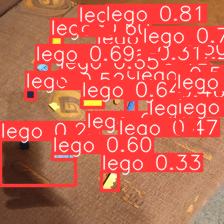

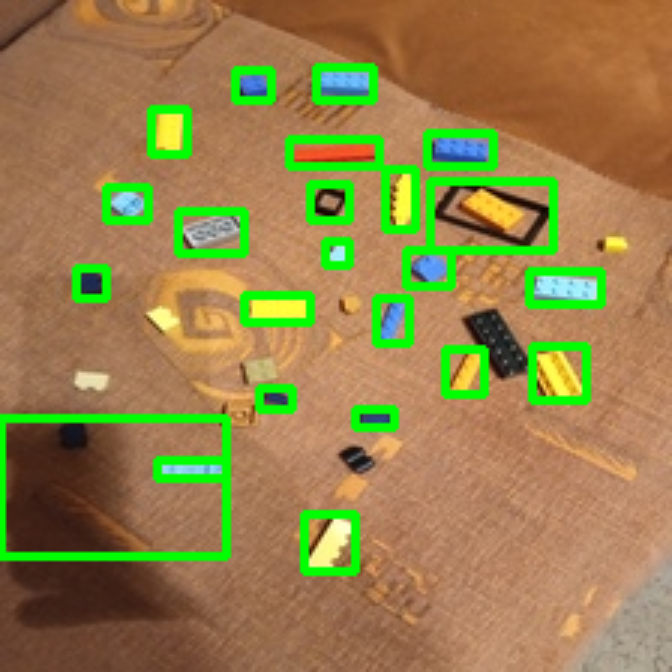

In [ ]:
name = '32_3.jpg'
test_image = 'data/imgs/' + name

# Initialize YOLO with the loaded configuration
yolo = YOLO('RUBEN_YOLO.pt')

bbs = run_yolo(yolo, test_image)
img = loadImage(name)
img_bb = drawBB(img, bbs)
img_bb = cv2.resize(img_bb, (0, 0), fx=3, fy=3)
render(img_bb)

Failed to mask image
Failed to mask image
Failed to mask image
Failed to mask image
Failed to mask image
Failed to mask image


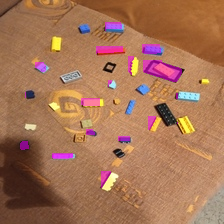

In [ ]:
bb_imgs = getBBImages(img, bbs)
masks = []

for box in bb_imgs:
    # render(box)
    img_lego, mask = maskLego(box)
    masks.append(mask)
    # render(img_lego)


img_neon = img.copy()

for mask, bb in zip(masks, bbs):
    x1, y1, x2, y2 = [int(x) for x in bb]
    
    # Apply the neon effect to the bounding box
    for y in range(y1, y2):
        for x in range(x1, x2):
            if mask[y - y1, x - x1]:
                neon = (img_neon[y, x] + [255, 0, 255] ) / 2
                img_neon[y, x] = np.uint8(neon)
    
# Display the image with the neon bounding boxes
render(img_neon)


In [ ]:
# Evaluate YOLO for all images in the dataset using Jaccard Index

def evaluate_yolo(yolo, data_dir, conf=0.25, iou=0.7):
    jaccard_indices = []
    for img_name in get_file_names(data_dir):
        img_path = os.path.join(data_dir, img_name)
        predicted_boxes = run_yolo(yolo, img_path, conf, iou, showImage=False)
        gt = getGroundTruths(img_name[:-4])
        matches = match_bounding_boxes(gt, predicted_boxes)
        jaccard_indices.extend([match[2] for match in matches])
    return jaccard_indices

jaccard_indices = evaluate_yolo(yolo, 'data/imgs')
print(f'Mean Jaccard Index: {np.mean(jaccard_indices)}')
print(f'Median Jaccard Index: {np.median(jaccard_indices)}')

Mean Jaccard Index: 0.8217892757702059
Median Jaccard Index: 0.8968868187309262
